# Ontological Foundations for Cognitive Robotics Systems

This notebook demonstrates how to:
1. Process RDF files (.ttl) and analyze entity occurrences
2. Handle corresponding image files
3. Enrich knowledge graphs with image schema information
4. Visualize and compare RDF graphs

## Initial Setup
First, we'll handle the required setup for local environment:


In [40]:
# Install required packages (run this if not already installed)
!pip install rdflib pillow anthropic networkx matplotlib dash dash-cytoscape


## Set up API Key
The API key is stored in `claude_api_key.txt` in the current directory.


In [41]:
def get_api_key():
    try:
        with open('claude_api_key.txt', 'r') as f:
            api_key = f.read().strip()
        return api_key
    except FileNotFoundError:
        print("Error: claude_api_key.txt not found. Please create this file with your API key.")
        return None


In [ ]:
# Setup Tutorial Data (Run this cell first in Colab)
# This cell downloads the tutorial data directly from GitHub

import os
import sys
import zipfile
import requests

# Check if we're in Colab
try:
    import google.colab
    IN_COLAB = True
    print("🚀 Setting up tutorial in Google Colab...")
    
    # GitHub repository URL
    REPO_URL = "https://github.com/StenDoipanni/demos-tutorials/archive/main.zip"
    
    print("📥 Downloading tutorial data from GitHub...")
    
    # Create data directory
    data_dir = "/content/tutorial-fois-2025"
    os.makedirs(data_dir, exist_ok=True)
    
    try:
        # Download the repository
        response = requests.get(REPO_URL)
        response.raise_for_status()
        
        # Save zip file
        zip_path = "/content/tutorial_data.zip"
        with open(zip_path, 'wb') as f:
            f.write(response.content)
        
        # Extract zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("/content/")
        
        # Move tutorial files to the right location
        extracted_dir = "/content/demos-tutorials-main"
        tutorial_dir = "/content/demos-tutorials-main/tutorial-fois-2025"
        
        if os.path.exists(tutorial_dir):
            # Copy all files from tutorial directory
            import shutil
            for item in os.listdir(tutorial_dir):
                src = os.path.join(tutorial_dir, item)
                dst = os.path.join(data_dir, item)
                if os.path.isdir(src):
                    shutil.copytree(src, dst, dirs_exist_ok=True)
                else:
                    shutil.copy2(src, dst)
            
            # Clean up
            shutil.rmtree(extracted_dir)
            os.remove(zip_path)
            
            print("✅ Tutorial data downloaded and extracted successfully!")
            
            # Verify the setup
            event_frames_dir = os.path.join(data_dir, "event_frames")
            if os.path.exists(event_frames_dir):
                ttl_files = [f for f in os.listdir(event_frames_dir) if f.endswith('.ttl')]
                print(f"📊 Found {len(ttl_files)} TTL files in event_frames")
                
                # Count files in subdirectories
                total_ttl = 0
                total_png = 0
                for root, dirs, files in os.walk(event_frames_dir):
                    for file in files:
                        if file.endswith('.ttl'):
                            total_ttl += 1
                        elif file.endswith('.png'):
                            total_png += 1
                
                print(f"📊 Total: {total_ttl} TTL files, {total_png} PNG files")
            else:
                print("⚠️  event_frames directory not found")
        else:
            print("❌ Tutorial directory not found in repository")
            
    except Exception as e:
        print(f"❌ Error downloading from GitHub: {e}")
        print("Creating fallback sample data...")
        
        # Create fallback sample data
        os.makedirs('/content/tutorial-fois-2025/event_frames', exist_ok=True)
        
        sample_ttl = """@prefix log: <file://./log.owl#> .

log:contact1 a log:Contact .
log:support1 a log:Support .
log:cutting1 a log:Cutting .
log:person1 a log:Person .
log:knife1 a log:Knife .
"""
        
        for i in range(1, 4):
            with open(f'/content/tutorial-fois-2025/event_frames/sample{i}.ttl', 'w') as f:
                f.write(sample_ttl)
        
        print("✅ Fallback sample data created")
    
    print("🎉 Setup complete! You can now run the tutorial cells.")
    
except ImportError:
    IN_COLAB = False
    print("Running locally - no setup needed")


In [ ]:
import os
import glob

# Check if we're in Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("Running locally")

# Setup data directory based on environment
if IN_COLAB:
    # Try multiple possible locations in Colab
    possible_dirs = [
        '/content/tutorial-fois-2025',  # From GitHub download
        '/content/drive/MyDrive/tutorial-fois-2025',  # Google Drive (fallback)
        '/content/event_frames'  # Direct upload (fallback)
    ]
    
    DATA_DIR = None
    for dir_path in possible_dirs:
        if os.path.exists(dir_path):
            DATA_DIR = dir_path
            break
    
    if DATA_DIR is None:
        print("No data directory found. Please run the setup cell above first!")
        print("The setup cell will download all data from GitHub automatically.")
        DATA_DIR = '/content/tutorial-fois-2025'  # Default fallback
else:
    # Local environment
    DATA_DIR = '/Users/stefanodegiorgis/Desktop/tutorial-fois-2025'

print(f"Main data directory: {os.path.abspath(DATA_DIR)}")
print(f"Looking for subfolders with .ttl and image files (.jpg/.png)")

# List available subfolders
if os.path.exists(DATA_DIR):
    subfolders = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
    print(f"Found {len(subfolders)} subfolders:")
    for folder in subfolders:
        print(f"  - {folder}")
        
    # Check event_frames specifically
    event_frames_path = os.path.join(DATA_DIR, "event_frames")
    if os.path.exists(event_frames_path):
        print(f"\n📁 Event frames directory found!")
        event_files = os.listdir(event_frames_path)
        ttl_count = len([f for f in event_files if f.endswith('.ttl')])
        png_count = len([f for f in event_files if f.endswith('.png')])
        dir_count = len([f for f in event_files if os.path.isdir(os.path.join(event_frames_path, f))])
        
        print(f"  - {ttl_count} TTL files")
        print(f"  - {png_count} PNG files") 
        print(f"  - {dir_count} subdirectories")
        
        # List subdirectories
        for item in event_files:
            item_path = os.path.join(event_frames_path, item)
            if os.path.isdir(item_path):
                sub_ttl = len([f for f in os.listdir(item_path) if f.endswith('.ttl')])
                sub_png = len([f for f in os.listdir(item_path) if f.endswith('.png')])
                print(f"    📂 {item}: {sub_ttl} TTL, {sub_png} PNG files")
else:
    print(f"Warning: Directory {DATA_DIR} does not exist!")
    if IN_COLAB:
        print("Please run the setup cell above to download data from GitHub!")
    else:
        print("Please check your local data directory path.")


Data directory: /content/event_frames
Please place your .ttl and image files in: /content/event_frames


In [43]:
from rdflib import Graph, Namespace, RDF
from PIL import Image
import anthropic
import json
from collections import Counter
from typing import List, Dict, Tuple, Optional
import base64
from io import BytesIO
import networkx as nx
import matplotlib.pyplot as plt
from rdflib.namespace import split_uri
from dash import Dash, html
import dash_cytoscape as cyto
import webbrowser
from threading import Timer


In [ ]:
prompt_base_graph = """
You receive an image (IMG) and an RDF graph (KG) serialised in Turtle syntax.

Your goal is to extend KG with more knowledge about sensorimotor and spatial dynamics that can be assumed, but it is not explicit. In particular, you have to focus on image schematic knowledge, considering the following image schemas:
[Movement, Source_Path_Goal, Contact, Link, Containment, Balance, Center_Periphery, Blockage]

Using IMG to better understand the sensorimotor dynamics elements as linking points, add any further elements you need to extract implicit knowledge about: Image Schemas.

Add Image Schemas triples to the KG considering the original graph KG and using existing entities as anchoring points for the new triples.

IMPORTANT: Limit your response to a maximum of 50 additional triples to keep the output manageable. Focus on the most important image schema relationships.

Respond ONLY with the Turtle syntax, make sure that the original input is in correct Turtle, if not correct it, without any additional text or explanations."""


In [ ]:
prompt_enriched_graph = """
You receive an RDF graph (KG) serialised in Turtle syntax. The graph focuses on knowledge about image-schematic relations, namely in particular spatial and force dynamics.

Your goal is to extend KG with more knowledge about:

**Causal Relations** : when two events mentioned in a text have a causal dependence.

**Event Sequences** : when two events mentioned in a text are in a temporal sequence.

**Implied Future Events** : when two events mentioned in a text have an implied temporal dependence sequence.

**Potential non-Events** : A potential non-event that is prevented from happening due to other events.

Use the entities in the graph as anchoring points for your knowledge enrichment.

IMPORTANT: Limit your response to a maximum of 30 additional triples to keep the output manageable. Focus on the most important causal and temporal relationships.

IMPORTANT: Respond ONLY with the Turtle syntax, make sure that the original input is in correct Turtle, if not correct it and then generate correct Turtle syntax, without any additional text or explanations."""


In [ ]:
# Define custom namespace for the log entities
LOG = Namespace("log:")

class RDFImageProcessor:
    """A class to process RDF (.ttl) files and their corresponding images from nested folder structure"""

    def __init__(self, main_folder_path: str):
        """Initialize the processor with the main folder path containing subfolders."""
        self.main_folder_path = main_folder_path
        self.client = anthropic.Anthropic(api_key=get_api_key())
        self.entities_of_interest = [
            LOG.Contact, LOG.Support, LOG.Cutting,
            LOG.Stabbing, LOG.Motion
        ]
        self.file_pairs = self._discover_file_pairs()

    def _discover_file_pairs(self) -> List[Dict]:
        """Discover all TTL and image file pairs across subfolders, recursively."""
        file_pairs = []
        
        if not os.path.exists(self.main_folder_path):
            print(f"Warning: Main folder {self.main_folder_path} does not exist!")
            return file_pairs
            
        # Check if we have a direct event_frames folder (common structure)
        event_frames_path = os.path.join(self.main_folder_path, "event_frames")
        if os.path.exists(event_frames_path):
            print("Found event_frames directory, processing recursively...")
            search_path = event_frames_path
        else:
            print("No event_frames directory found, searching main folder...")
            search_path = self.main_folder_path
        
        # Recursively find all TTL files
        ttl_files = []
        for root, dirs, files in os.walk(search_path):
            for file in files:
                if file.endswith('.ttl'):
                    ttl_files.append(os.path.join(root, file))
        
        print(f"Found {len(ttl_files)} TTL files in total")
        
        for ttl_file in ttl_files:
            # Get the base name without extension
            base_name = os.path.splitext(os.path.basename(ttl_file))[0]
            
            # Get the directory containing this TTL file
            ttl_dir = os.path.dirname(ttl_file)
            
            # Determine subfolder name (relative to search_path)
            if search_path == event_frames_path:
                # For event_frames, get the relative path from event_frames
                rel_path = os.path.relpath(ttl_dir, event_frames_path)
                if rel_path == '.':
                    subfolder_name = "event_frames"
                    relative_path = base_name
                else:
                    subfolder_name = f"event_frames/{rel_path}"
                    relative_path = f"{rel_path}/{base_name}"
            else:
                # For main folder search
                rel_path = os.path.relpath(ttl_dir, self.main_folder_path)
                if rel_path == '.':
                    subfolder_name = "root"
                    relative_path = base_name
                else:
                    subfolder_name = rel_path
                    relative_path = f"{rel_path}/{base_name}"
            
            # Look for corresponding image files (.jpg, .jpeg, or .png)
            image_extensions = ['.jpg', '.jpeg', '.png']
            image_file = None
            
            for ext in image_extensions:
                potential_image = os.path.join(ttl_dir, f"{base_name}{ext}")
                if os.path.exists(potential_image):
                    image_file = potential_image
                    break
            
            # Include TTL files even if no corresponding image is found
            file_pairs.append({
                'subfolder': subfolder_name,
                'filename': base_name,
                'ttl_path': ttl_file,
                'image_path': image_file,  # Can be None
                'relative_path': relative_path
            })
        
        # Count files with and without images
        files_with_images = sum(1 for pair in file_pairs if pair['image_path'] is not None)
        files_without_images = len(file_pairs) - files_with_images
        
        print(f"Discovered {len(file_pairs)} TTL files:")
        print(f"  - {files_with_images} with corresponding images")
        print(f"  - {files_without_images} without images (will skip image enrichment)")
        
        # Show some examples
        if file_pairs:
            print(f"\nExample files found:")
            for i, pair in enumerate(file_pairs[:5]):  # Show first 5
                image_status = "✅" if pair['image_path'] else "❌"
                print(f"  {i+1}. {pair['relative_path']} {image_status}")
            if len(file_pairs) > 5:
                print(f"  ... and {len(file_pairs) - 5} more files")
        
        return file_pairs

    def _convert_to_jpeg(self, image_path: str) -> str:
        """Convert image to JPEG format and return the converted file path."""
        if not os.path.exists(image_path):
            return image_path
            
        # Check if it's already a JPEG
        if image_path.lower().endswith(('.jpg', '.jpeg')):
            return image_path
            
        try:
            # Open the image
            with Image.open(image_path) as img:
                # Convert to RGB if necessary (for PNG with transparency)
                if img.mode in ('RGBA', 'LA', 'P'):
                    # Create a white background
                    background = Image.new('RGB', img.size, (255, 255, 255))
                    if img.mode == 'P':
                        img = img.convert('RGBA')
                    background.paste(img, mask=img.split()[-1] if img.mode == 'RGBA' else None)
                    img = background
                elif img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # Create new filename with .jpg extension
                base_name = os.path.splitext(image_path)[0]
                jpeg_path = f"{base_name}.jpg"
                
                # Save as JPEG
                img.save(jpeg_path, 'JPEG', quality=85, optimize=True)
                
                print(f"✅ Converted {os.path.basename(image_path)} to JPEG")
                return jpeg_path
                
        except Exception as e:
            print(f"⚠️  Error converting {image_path} to JPEG: {e}")
            return image_path

    def count_entity_occurrences(self, ttl_path: str) -> Dict:
        """Count occurrences of entities of interest in a TTL file."""
        g = Graph()
        g.parse(ttl_path, format='turtle')

        # Create local namespace to match file
        LOCAL = Namespace("file://./log.owl#")

        # Initialize counts with local namespace entities
        entities_local = [
            LOCAL.Contact, LOCAL.Support, LOCAL.Cutting,
            LOCAL.Stabbing, LOCAL.Motion
        ]
        counts = {str(entity).replace(str(LOCAL), "log:"): 0 for entity in entities_local}

        for s, p, o in g:
            if p == RDF.type:
                o_str = str(o).replace(str(LOCAL), "log:")
                if o_str in counts:
                    counts[o_str] += 1

        return counts

    def find_top_files(self, min_files: int = 5, max_files: int = 20) -> List[Tuple[str, Dict]]:
        """Find TTL files with the highest occurrences of entities of interest."""
        file_counts = []

        for file_pair in self.file_pairs:
            counts = self.count_entity_occurrences(file_pair['ttl_path'])
            total_count = sum(counts.values())
            file_counts.append((file_pair['relative_path'], counts, total_count, file_pair))

        file_counts.sort(key=lambda x: x[2], reverse=True)
        num_files = min(max(min_files, len(file_counts)), max_files)
        return [(fc[0], fc[1], fc[3]) for fc in file_counts[:num_files]]

    def display_file_pair(self, file_info) -> Tuple[Graph, Optional[Image.Image]]:
        """Display and return the TTL content and corresponding image."""
        if isinstance(file_info, str):
            # Find the file pair by relative path
            file_pair = None
            for pair in self.file_pairs:
                if pair['relative_path'] == file_info:
                    file_pair = pair
                    break
            if not file_pair:
                print(f"Error: File {file_info} not found!")
                return Graph(), None
        else:
            file_pair = file_info

        g = Graph()
        g.parse(file_pair['ttl_path'], format='turtle')
        print(f"\nContents of {file_pair['relative_path']}.ttl:")
        print(g.serialize(format='turtle'))

        img = None
        if os.path.exists(file_pair['image_path']):
            img = Image.open(file_pair['image_path'])
            display(img)  # Jupyter notebook display
        else:
            print(f"Warning: No corresponding image found for {file_pair['relative_path']}")

        return g, img

    def enrich_knowledge(self, file_info, custom_prompt=None) -> Graph:
        """Enrich knowledge graph with image schema information."""
        if isinstance(file_info, str):
            # Find the file pair by relative path
            file_pair = None
            for pair in self.file_pairs:
                if pair['relative_path'] == file_info:
                    file_pair = pair
                    break
            if not file_pair:
                print(f"Error: File {file_info} not found!")
                return Graph()
        else:
            file_pair = file_info

        # Check if image file exists
        if file_pair['image_path'] is None or not os.path.exists(file_pair['image_path']):
            print(f"⚠️  No image file found for {file_pair['relative_path']}")
            print("Skipping image-based enrichment. Only processing TTL content.")
            
            # Process without image - use text-only prompt
            with open(file_pair['ttl_path'], 'r') as ttl_file:
                ttl_content = ttl_file.read()

            # Use custom prompt or default text-only prompt
            if custom_prompt:
                prompt_to_use = custom_prompt
            else:
                prompt_to_use = prompt_base_graph

            response = self.client.messages.create(
                model="claude-3-7-sonnet-20250219",
                max_tokens=4096,
                messages=[{
                    "role": "user",
                    "content": f"{prompt_to_use}\n\nThe Turtle content is:\n{ttl_content}"
                }]
            )
        else:
            # Process with image - convert to JPEG first
            jpeg_path = self._convert_to_jpeg(file_pair['image_path'])
            
            with open(jpeg_path, 'rb') as img_file:
                img_data = base64.b64encode(img_file.read()).decode()

            with open(file_pair['ttl_path'], 'r') as ttl_file:
                ttl_content = ttl_file.read()

            # Use custom prompt or default prompt
            if custom_prompt:
                prompt_to_use = custom_prompt
            else:
                prompt_to_use = prompt_base_graph

            response = self.client.messages.create(
                model="claude-3-7-sonnet-20250219", #"claude-3-opus-20240229",
                max_tokens=4096,
                messages=[{
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": f"{prompt_to_use}\n\nThe Turtle content is:\n{ttl_content}"
                        },
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": "image/jpeg",
                                "data": img_data
                            }
                        }
                    ]
                }]
            )

        # Extract only the Turtle content from response
        turtle_content = response.content
        if isinstance(response.content, list):
            turtle_content = response.content[0].text if response.content else ""

        print(f"\n🔍 DEBUG: Claude's TTL Response for {file_pair['relative_path']}:")
        print("="*80)
        print(turtle_content)
        print("="*80)

        new_graph = Graph()
        try:
            new_graph.parse(data=turtle_content, format='turtle')
            print(f"✅ Successfully parsed Claude's response into RDF graph")
        except Exception as e:
            print(f"❌ Error parsing response: {e}")
            print(f"Response content: {turtle_content}")
            return Graph()

        return new_graph

    def enrich_further_knowledge(self, graph: Graph, custom_prompt=None) -> Graph:
        """Enrich knowledge graph with causal and temporal relations."""

        # Convert input graph to turtle string
        ttl_content = graph.serialize(format='turtle')
        
        print(f"\n🔍 DEBUG: Input to causal enrichment:")
        print("="*80)
        print(ttl_content)
        print("="*80)

        # Use custom prompt or default prompt
        if custom_prompt:
            prompt_to_use = custom_prompt
        else:
            prompt_to_use = prompt_enriched_graph

        response = self.client.messages.create(
            model="claude-3-7-sonnet-20250219",
            max_tokens=4096,
            messages=[{
                "role": "user",
                "content": f"{prompt_to_use}\n\nThe Turtle content is:\n{ttl_content}"
            }]
        )

        # Extract only the Turtle content from response
        turtle_content = response.content
        if isinstance(response.content, list):
            turtle_content = response.content[0].text if response.content else ""

        print(f"\n🔍 DEBUG: Claude's Causal Enrichment Response:")
        print("="*80)
        print(turtle_content)
        print("="*80)

        new_graph = Graph()
        try:
            new_graph.parse(data=turtle_content, format='turtle')
            print(f"✅ Successfully parsed Claude's causal enrichment response into RDF graph")
        except Exception as e:
            print(f"❌ Error parsing response: {e}")
            print(f"Response content: {turtle_content}")
            return Graph()

        return new_graph

    def visualize_graph_colab(self, graph: Graph, title: str = "RDF Graph"):
        """Create a simple text-based visualization for Colab."""
        print(f"\n{'='*60}")
        print(f"📊 {title}")
        print(f"{'='*60}")
        
        # Count different types of entities
        subjects = set()
        predicates = set()
        objects = set()
        types = set()
        
        for s, p, o in graph:
            subjects.add(str(s))
            predicates.add(str(p))
            objects.add(str(o))
            
            # Check for type relationships
            if str(p) == "http://www.w3.org/1999/02/22-rdf-syntax-ns#type":
                types.add(str(o))
        
        print(f"📈 Graph Statistics:")
        print(f"   - Total triples: {len(graph)}")
        print(f"   - Unique subjects: {len(subjects)}")
        print(f"   - Unique predicates: {len(predicates)}")
        print(f"   - Unique objects: {len(objects)}")
        print(f"   - Type relationships: {len(types)}")
        
        # Show some example triples
        print(f"\n🔍 Sample Triples:")
        count = 0
        for s, p, o in graph:
            if count < 10:  # Show first 10 triples
                s_short = str(s).split('#')[-1] if '#' in str(s) else str(s)
                p_short = str(p).split('#')[-1] if '#' in str(p) else str(p)
                o_short = str(o).split('#')[-1] if '#' in str(o) else str(o)
                print(f"   {s_short} --{p_short}--> {o_short}")
                count += 1
            else:
                break
        
        if len(graph) > 10:
            print(f"   ... and {len(graph) - 10} more triples")
        
        print(f"\n📋 Full TTL Content:")
        print("-" * 60)
        print(graph.serialize(format='turtle'))
        print("-" * 60)

    def visualize_graph_interactive_colab(self, graph: Graph, title: str = "RDF Graph"):
        """Create interactive visualization for Colab using dash-cytoscape."""
        try:
            # Check if we're in Colab
            import google.colab
            IN_COLAB = True
        except ImportError:
            IN_COLAB = False
        
        if IN_COLAB:
            # Use the proper dash-cytoscape visualization
            app = self._create_cytoscape_app(graph, title)
            
            # For Colab, we need to run the app differently
            print(f"🎨 Starting interactive visualization: {title}")
            print("📱 The visualization will appear below this cell...")
            
            # Run the app in Colab
            app.run_server(debug=False, port=8050, host='127.0.0.1', use_reloader=False)
        else:
            # Local environment - use the original method
            app = self._create_cytoscape_app(graph, title)
            app.run_server(debug=False, port=8050, host='127.0.0.1')
    
    def _create_cytoscape_app(self, graph: Graph, title: str = "RDF Graph"):
        """Create the dash-cytoscape app (extracted from old tutorial)."""
        from rdflib import RDF, OWL
        from dash import Dash, html
        import dash_cytoscape as cyto
        from rdflib.namespace import split_uri
        
        app = Dash(__name__)
        nodes = []
        edges = []
        added_nodes = set()

        nodes_to_color_red = set()

        # First pass: identify nodes that should be red
        for s, p, o in graph:
            s_label = split_uri(s)[1] if isinstance(s, (type(None), str)) and '#' in str(s) else str(s)
            o_label = split_uri(o)[1] if isinstance(o, (type(None), str)) and '#' in str(o) else str(o)

            if p == RDF.type and "schematicRelation" in s_label:
                nodes_to_color_red.add(o_label)

        exclude_patterns = [
            (None, RDF.type, OWL.NamedIndividual),
            (None, RDF.type, OWL.ObjectProperty),
            (None, RDF.type, OWL.DatatypeProperty)
        ]

        def get_node_properties(label):
            properties = {
                'color': '#BFD7ED',  # Default light blue
                'text_color': '#000000',  # Black text
            }

            # SchematicRelation nodes
            if "schematicRelation" in label:
                properties['color'] = '#000080'  # Dark blue
                properties['text_color'] = '#FFFFFF'  # White text

            # Nodes that are types of schematicRelation nodes
            elif label in nodes_to_color_red:
                properties['color'] = '#FF0000'  # Red
                properties['text_color'] = '#FFFFFF'  # White text

            return properties

        # Process nodes and edges
        for s, p, o in graph:
            if any(all(x is None or y is None or x == y for x, y in zip([s, p, o], pattern)) for pattern in exclude_patterns):
                continue

            s_label = split_uri(s)[1] if isinstance(s, (type(None), str)) and '#' in str(s) else str(s)
            o_label = split_uri(o)[1] if isinstance(o, (type(None), str)) and '#' in str(o) else str(o)
            p_label = split_uri(p)[1] if '#' in str(p) else str(p).split('/')[-1]

            if s_label not in added_nodes:
                props = get_node_properties(s_label)
                nodes.append({
                    'data': {
                        'id': s_label,
                        'label': s_label,
                        'backgroundColor': props['color'],
                        'textColor': props['text_color']
                    }
                })
                added_nodes.add(s_label)

            if o_label not in added_nodes:
                props = get_node_properties(o_label)
                nodes.append({
                    'data': {
                        'id': o_label,
                        'label': o_label,
                        'backgroundColor': props['color'],
                        'textColor': props['text_color']
                    }
                })
                added_nodes.add(o_label)

            edges.append({
                'data': {
                    'source': s_label,
                    'target': o_label,
                    'label': p_label
                }
            })

        # Define styles for nodes and edges
        node_stylesheet = {
            'selector': 'node',
            'style': {
                'content': 'data(label)',
                'background-color': 'data(backgroundColor)',
                'color': 'data(textColor)',
                'font-size': '12px',
                'text-wrap': 'wrap',
                'text-max-width': '100px',
                'padding': '15px',
                'text-valign': 'center',
                'text-halign': 'center',
                'text-outline-width': 2,
                'text-outline-color': 'data(backgroundColor)',
                'text-outline-opacity': 1
            }
        }

        edge_stylesheet = {
            'selector': 'edge',
            'style': {
                'content': 'data(label)',
                'curve-style': 'bezier',
                'target-arrow-shape': 'triangle',
                'font-size': '10px',
                'text-rotation': 'autorotate',
                'line-color': '#666',
                'width': 1,
                'text-margin-y': '-10px',
                'text-background-color': '#FFFFFF',
                'text-background-opacity': 0.7,
                'text-background-padding': '2px'
            }
        }

        app.layout = html.Div([
            html.H1(title),
            cyto.Cytoscape(
                id='cytoscape',
                layout={
                    'name': 'cose',
                    'idealEdgeLength': 200,
                    'nodeOverlap': 20,
                    'refresh': 20,
                    'fit': True,
                    'padding': 30,
                    'randomize': False,
                    'componentSpacing': 200,
                    'nodeRepulsion': 6000,
                    'edgeElasticity': 100,
                    'nestingFactor': 1.2,
                    'gravity': 80,
                    'numIter': 1000,
                    'initialTemp': 200,
                    'coolingFactor': 0.95,
                    'minTemp': 1.0
                },
                style={'width': '100%', 'height': '800px'},
                elements=nodes + edges,
                stylesheet=[node_stylesheet, edge_stylesheet]
            )
        ])
        
        return app

    def print_graphs(self, original_graph: Graph, new_graph: Graph, mode: str = 'both'):
        """Print graphs based on the specified mode."""
        if mode.lower() == 'original' or mode.lower() == 'both':
            print("\nOriginal Graph:")
            print(original_graph.serialize(format='turtle'))

        if mode.lower() == 'new' or mode.lower() == 'both':
            print("\nNew Graph:")
            print(new_graph.serialize(format='turtle'))


    def visualize_original_interactive(self, file_info, port=8050):
        """Create interactive visualization of original TTL file."""
        if isinstance(file_info, str):
            # Find the file pair by relative path
            file_pair = None
            for pair in self.file_pairs:
                if pair['relative_path'] == file_info:
                    file_pair = pair
                    break
            if not file_pair:
                print(f"Error: File {file_info} not found!")
                return
        else:
            file_pair = file_info

        g = Graph()
        g.parse(file_pair['ttl_path'], format='turtle')
        app = visualize_graph_interactive(g, port=port, title=f"Base Graph - {file_pair['relative_path']}")
        app.run(debug=False, port=port, host='127.0.0.1')

    def visualize_enriched_interactive(self, enriched_graph: Graph, port=8051, filename: str = ""):
        """Create interactive visualization of enriched graph."""
        app = visualize_graph_interactive(enriched_graph, port=port, title=f"Enriched Graph - {filename}")
        app.run(debug=False, port=port, host='127.0.0.1')


## Initialize the Processor
Now we can initialize the processor using our local path:


In [47]:
processor = RDFImageProcessor(DATA_DIR)


## 📋 Tutorial Instructions

**This tutorial demonstrates knowledge graph enrichment using image schemas and causal relations.**

### Prerequisites:
1. **API Key Setup**: Create a file named `claude_api_key.txt` in the current directory containing your Anthropic API key
2. **Data**: All tutorial data is automatically downloaded from GitHub

### Workflow:
1. **Select a file** to process from the available TTL files
2. **Load and visualize** the original graph
3. **Enrich with image schemas** using Claude AI
4. **Add causal relations** for temporal understanding
5. **Experiment with custom enrichment** (optional)

**Ready to start! Run the cells below in order.**


In [ ]:
# Find top files (minimum 1, maximum 20)
top_files = processor.find_top_files(min_files=1, max_files=20)

print(f"Found {len(top_files)} files total")
print("Top files by entity occurrences:")
for i, (filename, counts, file_pair) in enumerate(top_files):
    print(f"\n{i}: {filename}")
    print(f"   Subfolder: {file_pair['subfolder']}")
    for entity, count in counts.items():
        print(f"   {entity}: {count}")

if len(top_files) == 0:
    print("\nNo files found! Please check:")
    print("1. Your Google Drive folder path is correct")
    print("2. The folder contains subfolders with .ttl and image files")
    print("3. File names match (e.g., frame0.ttl and frame0.png)")


Top files by entity occurrences:

sample2.ttl:
  log:Contact: 1
  log:Support: 0
  log:Cutting: 0
  log:Stabbing: 1
  log:Motion: 1

sample1.ttl:
  log:Contact: 1
  log:Support: 1
  log:Cutting: 1
  log:Stabbing: 0
  log:Motion: 0

sample3.ttl:
  log:Contact: 1
  log:Support: 1
  log:Cutting: 0
  log:Stabbing: 0
  log:Motion: 1


In [ ]:
# Debug: Check what files were discovered
print("=== DEBUG: File Discovery ===")
print(f"Total file pairs discovered: {len(processor.file_pairs)}")
print("\nAll discovered file pairs:")
for i, pair in enumerate(processor.file_pairs):
    print(f"{i}: {pair['relative_path']} (subfolder: {pair['subfolder']})")
    print(f"   TTL: {pair['ttl_path']}")
    print(f"   Image: {pair['image_path']}")
    print(f"   TTL exists: {os.path.exists(pair['ttl_path'])}")
    if pair['image_path'] is not None:
        print(f"   Image exists: {os.path.exists(pair['image_path'])}")
    else:
        print(f"   Image exists: False (no image file)")
    print()

if len(processor.file_pairs) == 0:
    print("No file pairs found. Let's check the directory structure:")
    print(f"Main directory: {DATA_DIR}")
    print(f"Directory exists: {os.path.exists(DATA_DIR)}")
    if os.path.exists(DATA_DIR):
        print("Contents of main directory:")
        for item in os.listdir(DATA_DIR):
            item_path = os.path.join(DATA_DIR, item)
            print(f"  {item} (is_dir: {os.path.isdir(item_path)})")
            if os.path.isdir(item_path):
                print(f"    Contents: {os.listdir(item_path)}")


## 🔍 Step 1: File Selection
Based on the analysis above, select which file you want to process and visualize:


In [ ]:
# File Selection Options
# Option 1: Specify file by name (recommended)
selected_file_name = ""  # e.g., "protect_agent/prot_baby_ledge/frame0" or "sample1"

# Option 2: Use file index (if name is empty)
selected_file_index = 0  # Change this to select different files by index

# Find the file to process
selected_file_pair = None
selected_relative_path = None

if len(top_files) == 0:
    print("❌ No files found! Please check the debug output above.")
else:
    # Try to find file by name first
    if selected_file_name:
        for relative_path, counts, file_pair in top_files:
            if selected_file_name in relative_path:
                selected_file_pair = file_pair
                selected_relative_path = relative_path
                print(f"✅ Found file by name: {relative_path}")
                break
        
        if selected_file_pair is None:
            print(f"❌ File '{selected_file_name}' not found!")
            print("Available files:")
            for i, (relative_path, counts, file_pair) in enumerate(top_files):
                print(f"  {i}: {relative_path}")
    else:
        # Use index-based selection
        if selected_file_index < len(top_files):
            relative_path, counts, file_pair = top_files[selected_file_index]
            selected_file_pair = file_pair
            selected_relative_path = relative_path
            print(f"✅ Selected file by index: {relative_path}")
        else:
            print(f"❌ Error: Selected index {selected_file_index} is out of range. Available files: {len(top_files)}")
    
    if selected_file_pair:
        print(f"\n📁 Selected file: {selected_relative_path}")
        print(f"📂 Subfolder: {selected_file_pair['subfolder']}")
        print(f"📊 Entity counts: {counts}")
        
        print(f"\n✅ File selected! You can now run the subsequent cells to:")
        print(f"   1. Load and display the original graph")
        print(f"   2. Enrich with image schemas")
        print(f"   3. Enrich with causal relations")
        print(f"   4. Experiment with custom enrichment")



Contents of sample2.ttl:
@prefix log: <file://./log.owl#> .

log:stabbing1 a log:Stabbing ;
    log:hasAgent log:person2 ;
    log:hasContact log:contact2 ;
    log:hasInstrument log:sword1 ;
    log:hasMotion log:motion1 .

log:contact2 a log:Contact .

log:motion1 a log:Motion .

log:person2 a log:Person .

log:sword1 a log:Sword .




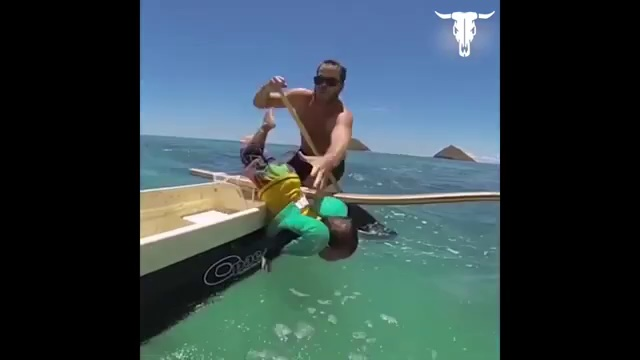

Error parsing response: at line 85 of <>:
Bad syntax (EOF found when expected verb in property list) at ^ in:
"...b':piercing1 .\n\nlog:tissueDisruption1 a log:TissueDisruption ;'^b''"
Response content: @prefix log: <file://./log.owl#> .
@prefix schema1: <file://./imageschema.owl#> .
@prefix causal: <file://./causal.owl#> .
@prefix temporal: <file://./temporal.owl#> .

log:stabbing1 a log:Stabbing ;
    schema1:exemplifies schema1:Source_Path_Goal ;
    schema1:hasCenter log:contactPoint1 ;
    schema1:hasGoal log:target1 ;
    schema1:hasPath log:motion1 ;
    schema1:hasSource log:person2 ;
    log:hasAgent log:person2 ;
    log:hasContact log:contact2 ;
    log:hasInstrument log:sword1 ;
    log:hasMotion log:motion1 ;
    causal:causes log:piercing1 ;
    causal:causes log:wounding1 ;
    temporal:precedesEvent log:piercing1 ;
    temporal:precedesEvent log:bleeding1 .

log:contact2 a log:Contact ;
    schema1:exemplifies schema1:Contact ;
    schema1:hasAgent log:sword1 ;
    sche

In [ ]:
## 📊 Step 2: Load and Display Original Graph
# This cell loads the original TTL file and displays its content

print("="*60)
print("STEP 1: LOADING ORIGINAL GRAPH")
print("="*60)

# Load the original graph from the selected TTL file
original_graph, image = processor.display_file_pair(selected_file_pair)

# Visualize the original graph
processor.visualize_graph_colab(original_graph, f"ORIGINAL GRAPH - {selected_relative_path}")

# Interactive visualization
print(f"\n🎨 Interactive Visualization:")
processor.visualize_graph_interactive_colab(original_graph, f"Original Graph - {selected_relative_path}")

# Store the original graph for use in subsequent cells
original_graph_global = original_graph


In [ ]:
## 🧠 Step 3: Enrich with Image Schemas
# This cell takes the original graph and enriches it with image schema knowledge

print("="*60)
print("STEP 2: IMAGE SCHEMA ENRICHMENT")
print("="*60)

# Enrich the original graph with image schemas
print(f"🔄 Enriching {selected_relative_path} with image schemas...")
enriched_graph = processor.enrich_knowledge(selected_file_pair)

# Visualize the enriched graph
processor.visualize_graph_colab(enriched_graph, f"ENRICHED GRAPH - {selected_relative_path}")

# Interactive visualization
print(f"\n🎨 Interactive Visualization:")
processor.visualize_graph_interactive_colab(enriched_graph, f"Enriched Graph - {selected_relative_path}")

# Store the enriched graph for use in subsequent cells
enriched_graph_global = enriched_graph


In [ ]:
## ⚡ Step 4: Enrich with Causal Relations
# This cell takes the enriched graph and adds causal/temporal relations

print("="*60)
print("STEP 3: CAUSAL ENRICHMENT")
print("="*60)

# Enrich the enriched graph with causal relations
print(f"🔄 Adding causal relations to {selected_relative_path}...")
causal_enriched_graph = processor.enrich_further_knowledge(enriched_graph_global)

# Visualize the causal enriched graph
processor.visualize_graph_colab(causal_enriched_graph, f"CAUSAL ENRICHED GRAPH - {selected_relative_path}")

# Interactive visualization
print(f"\n🎨 Interactive Visualization:")
processor.visualize_graph_interactive_colab(causal_enriched_graph, f"Causal Enriched Graph - {selected_relative_path}")

# Store the causal enriched graph for use in subsequent cells
causal_enriched_graph_global = causal_enriched_graph


In [ ]:
def visualize_graph_interactive(g, port=8050, title="RDF Graph"):
    """Create interactive visualization of RDF graph with fixed node labels."""
    from rdflib import RDF, OWL

    app = Dash(__name__)
    nodes = []
    edges = []
    added_nodes = set()

    nodes_to_color_red = set()

    # First pass: identify nodes that should be red
    for s, p, o in g:
        s_label = split_uri(s)[1] if isinstance(s, (type(None), str)) and '#' in str(s) else str(s)
        o_label = split_uri(o)[1] if isinstance(o, (type(None), str)) and '#' in str(o) else str(o)

        if p == RDF.type and "schematicRelation" in s_label:
            nodes_to_color_red.add(o_label)

    exclude_patterns = [
        (None, RDF.type, OWL.NamedIndividual),
        (None, RDF.type, OWL.ObjectProperty),
        (None, RDF.type, OWL.DatatypeProperty)
    ]

    def get_node_properties(label):

        properties = {
            'color': '#BFD7ED',  # Default light blue
            'text_color': '#000000',  # Black text
        }

        # SchematicRelation nodes
        if "schematicRelation" in label:
            properties['color'] = '#000080'  # Dark blue
            properties['text_color'] = '#FFFFFF'  # White text

        # Nodes that are types of schematicRelation nodes
        elif label in nodes_to_color_red:
            properties['color'] = '#FF0000'  # Red
            properties['text_color'] = '#FFFFFF'  # White text

        return properties

    # Process nodes and edges
    for s, p, o in g:
        if any(all(x is None or y is None or x == y for x, y in zip([s, p, o], pattern)) for pattern in exclude_patterns):
            continue

        s_label = split_uri(s)[1] if isinstance(s, (type(None), str)) and '#' in str(s) else str(s)
        o_label = split_uri(o)[1] if isinstance(o, (type(None), str)) and '#' in str(o) else str(o)
        p_label = split_uri(p)[1] if '#' in str(p) else str(p).split('/')[-1]

        if s_label not in added_nodes:
            props = get_node_properties(s_label)
            nodes.append({
                'data': {
                    'id': s_label,
                    'label': s_label,
                    'backgroundColor': props['color'],
                    'textColor': props['text_color']
                }
            })
            added_nodes.add(s_label)

        if o_label not in added_nodes:
            props = get_node_properties(o_label)
            nodes.append({
                'data': {
                    'id': o_label,
                    'label': o_label,
                    'backgroundColor': props['color'],
                    'textColor': props['text_color']
                }
            })
            added_nodes.add(o_label)

        edges.append({
            'data': {
                'source': s_label,
                'target': o_label,
                'label': p_label
            }
        })

    # Define styles for nodes and edges
    node_stylesheet = {
        'selector': 'node',
        'style': {
            'content': 'data(label)',
            'background-color': 'data(backgroundColor)',
            'color': 'data(textColor)',
            'font-size': '12px',
            'text-wrap': 'wrap',
            'text-max-width': '100px',
            'padding': '15px',
            'text-valign': 'center',
            'text-halign': 'center',
            'text-outline-width': 2,
            'text-outline-color': 'data(backgroundColor)',
            'text-outline-opacity': 1
        }
    }

    edge_stylesheet = {
        'selector': 'edge',
        'style': {
            'content': 'data(label)',
            'curve-style': 'bezier',
            'target-arrow-shape': 'triangle',
            'font-size': '10px',
            'text-rotation': 'autorotate',
            'line-color': '#666',
            'width': 1,
            'text-margin-y': '-10px',
            'text-background-color': '#FFFFFF',
            'text-background-opacity': 0.7,
            'text-background-padding': '2px'
        }
    }

    app.layout = html.Div([
        html.H1(title),
        cyto.Cytoscape(
            id='cytoscape',
            layout={
                'name': 'cose',
                'idealEdgeLength': 200,
                'nodeOverlap': 20,
                'refresh': 20,
                'fit': True,
                'padding': 30,
                'randomize': False,
                'componentSpacing': 200,
                'nodeRepulsion': 6000,
                'edgeElasticity': 100,
                'nestingFactor': 1.2,
                'gravity': 80,
                'numIter': 1000,
                'initialTemp': 200,
                'coolingFactor': 0.95,
                'minTemp': 1.0
            },
            style={'width': '100%', 'height': '800px'},
            elements=nodes + edges,
            stylesheet=[node_stylesheet, edge_stylesheet]
        )
    ])

    def open_browser():
        webbrowser.open_new_tab(f'http://127.0.0.1:{port}/')

    Timer(1, open_browser).start()
    return app


In [ ]:
## 🔬 Step 5: Custom Enrichment (Optional)
# This cell allows you to experiment with custom prompts for additional enrichment

print("="*60)
print("STEP 5: CUSTOM ENRICHMENT (OPTIONAL)")
print("="*60)

# Select which graph to use as input for custom enrichment
input_graph_choice = "enriched"  # Options: "original", "enriched", "causal_enriched"

# Available graphs
available_graphs = {
    "original": original_graph_global,
    "enriched": enriched_graph_global, 
    "causal_enriched": causal_enriched_graph_global
}

# Select the input graph
if input_graph_choice in available_graphs:
    input_graph = available_graphs[input_graph_choice]
    print(f"✅ Using {input_graph_choice} graph as input for custom enrichment")
    print(f"📊 Input graph has {len(input_graph)} triples")
else:
    print(f"❌ Invalid graph choice: {input_graph_choice}")
    print(f"Available options: {list(available_graphs.keys())}")
    input_graph = enriched_graph_global  # Default fallback

# Custom prompt for additional enrichment
custom_prompt = """
You receive an RDF graph (KG) serialised in Turtle syntax.

Your goal is to extend KG with additional information about movies that involve elements similar to those present in KG.

Add triples about:
- Movies and movie scenes including the same pair of entities
- Directors directing those movies
- Setting of the movies introduced

IMPORTANT: Limit your response to a maximum of 30 triples other than original graph.

Respond ONLY with the Turtle syntax, without any additional text or explanations.
"""

print(f"\n💡 Custom enrichment prompt:")
print("-" * 40)
print(custom_prompt)
print("-" * 40)

# Function to perform custom enrichment
def perform_custom_enrichment(input_graph, custom_prompt):
    """Perform custom enrichment on the selected input graph."""
    print(f"\n🔄 Performing custom enrichment...")
    
    # Convert graph to TTL string
    ttl_content = input_graph.serialize(format='turtle')
    
    # Create a temporary file pair for the enrichment function
    temp_file_pair = {
        'ttl_path': None,  # We'll pass the TTL content directly
        'image_path': None,
        'relative_path': f"custom_enrichment_from_{input_graph_choice}"
    }
    
    # Use the enrich_knowledge method with custom prompt
    # We need to modify the method to accept TTL content directly
    response = processor.client.messages.create(
        model="claude-3-7-sonnet-20250219",
        max_tokens=4096,
        messages=[{
            "role": "user",
            "content": f"{custom_prompt}\n\nThe Turtle content is:\n{ttl_content}"
        }]
    )
    
    # Extract and parse the response
    turtle_content = response.content
    if isinstance(response.content, list):
        turtle_content = response.content[0].text if response.content else ""
    
    print(f"\n🔍 DEBUG: Claude's Custom Enrichment Response:")
    print("="*80)
    print(turtle_content)
    print("="*80)
    
    # Parse the response into a new graph
    from rdflib import Graph
    custom_enriched_graph = Graph()
    try:
        custom_enriched_graph.parse(data=turtle_content, format='turtle')
        print(f"✅ Successfully parsed Claude's custom enrichment response")
        return custom_enriched_graph
    except Exception as e:
        print(f"❌ Error parsing response: {e}")
        return Graph()

# Perform the custom enrichment
custom_enriched_graph = perform_custom_enrichment(input_graph, custom_prompt)

# Visualize the custom enriched graph
if len(custom_enriched_graph) > 0:
    processor.visualize_graph_colab(custom_enriched_graph, f"CUSTOM ENRICHED GRAPH - {input_graph_choice}")
    
    # Interactive visualization
    print(f"\n🎨 Interactive Visualization:")
    processor.visualize_graph_interactive_colab(custom_enriched_graph, f"Custom Enriched Graph - {input_graph_choice}")
else:
    print("❌ No custom enrichment was performed due to parsing errors")


ObsoleteAttributeException: app.run_server has been replaced by app.run